In [17]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [8]:
fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/long_dye_tracers/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20170101_20181231.nc')
dep_idx = 39

In [18]:
def wrangle_df(river_dataframe, month, month_num, month_days):
    test = river_dataframe[['YEAR','DD', month]]
    mapping = {test.columns[0]: 'YYYY', test.columns[2]: 'DISCHARGE'}
    test2 = test.rename(columns=mapping)
    test2['MM'] = month_num
    test2 = test2.drop(test2[test2['DD'] > month_days].index)
    return test2

In [19]:
def add_dt(df):
    listy = [str(int(year)) for year in df['YYYY']]
    listm = [str.zfill(str(int(month)),2) for month in df['MM']]
    listd = [str.zfill(str(int(day)),2) for day in df['DD']]

    lst = list([listy, listm, listd])

    listdt = list(map('-'.join, zip(*lst)))

    date_format = '%Y-%m-%d'
    listdt_obj = [datetime.strptime(dt_str, date_format) for dt_str in listdt]

    return listdt_obj

In [20]:
def transform_df(df):
    January = wrangle_df(df, 'Jan', 1, 31)
    February = wrangle_df(df, 'Feb', 2, 28)
    March = wrangle_df(df, 'Mar', 3, 31)
    April = wrangle_df(df, 'Apr', 4, 30)
    May = wrangle_df(df, 'May', 5, 31)
    June = wrangle_df(df, 'Jun', 6, 30)
    July = wrangle_df(df, 'Jul', 7, 31)
    August = wrangle_df(df, 'Aug', 8, 31)
    September = wrangle_df(df, 'Sep', 9, 30)
    October = wrangle_df(df, 'Oct', 10, 31)
    November = wrangle_df(df, 'Nov', 11, 30)
    December = wrangle_df(df, 'Dec', 12, 31)

    df_new = pd.DataFrame(np.vstack((January.to_numpy(), February.to_numpy(), March.to_numpy(), April.to_numpy(), May.to_numpy(), June.to_numpy(), July.to_numpy(), August.to_numpy(), September.to_numpy(), October.to_numpy(), November.to_numpy(), December.to_numpy())), columns= ['YYYY', 'DD', 'DISCHARGE', 'MM'])
    
    df_new['DateTime'] = add_dt(df_new)

    return df_new

In [42]:
Fraser_obs = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/compare_daily_river/Fraser_Hope.csv',header=1)
Fraser_obs = Fraser_obs[Fraser_obs['PARAM'] == 1]
Fraser_obs = transform_df(Fraser_obs).sort_values(by='DateTime')

In [4]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [5]:
def make_ts_arr(jdepth, data):
    river_arr = data[:, 0:jdepth].sum(axis=3).sum(axis=2).sum(axis=1)
    return river_arr.to_numpy()

In [6]:
time = fw_rivers['time'].to_numpy()
Fraser_arr = make_ts_arr(dep_idx, fw_rivers.fraser_river)

In [50]:
obs_sel = (Fraser_obs['DateTime'] >= '2017-01-01') & (Fraser_obs['DateTime'] <= '2018-12-31')
Fraser_obs = Fraser_obs[obs_sel]

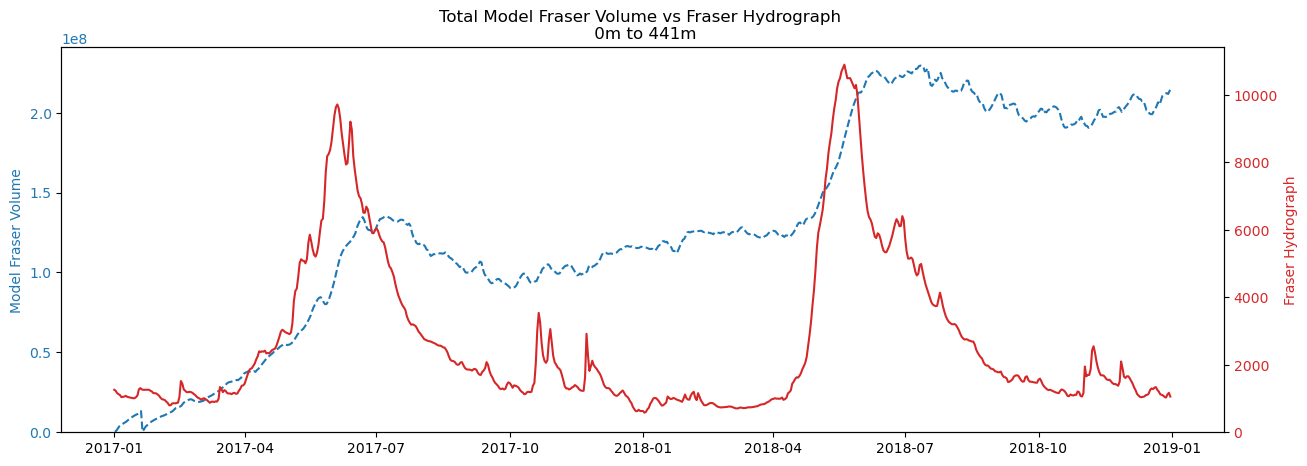

In [62]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

color1 = 'tab:blue'
ax1.set_title('Total Model Fraser Volume vs Fraser Hydrograph \n 0m to {}m'.format( int(float(fw_rivers['depth'][dep_idx].values))))
ax1.plot(time, Fraser_arr, linestyle='--', color=color1)
ax1.set_ylabel('Model Fraser Volume', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, None)

color2 = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(Fraser_obs['DateTime'], Fraser_obs['DISCHARGE'], color=color2)
ax2.set_ylabel('Fraser Hydrograph', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, None)

plt.savefig('timeseries_plots/Fraser_modelandobs_volume.png')

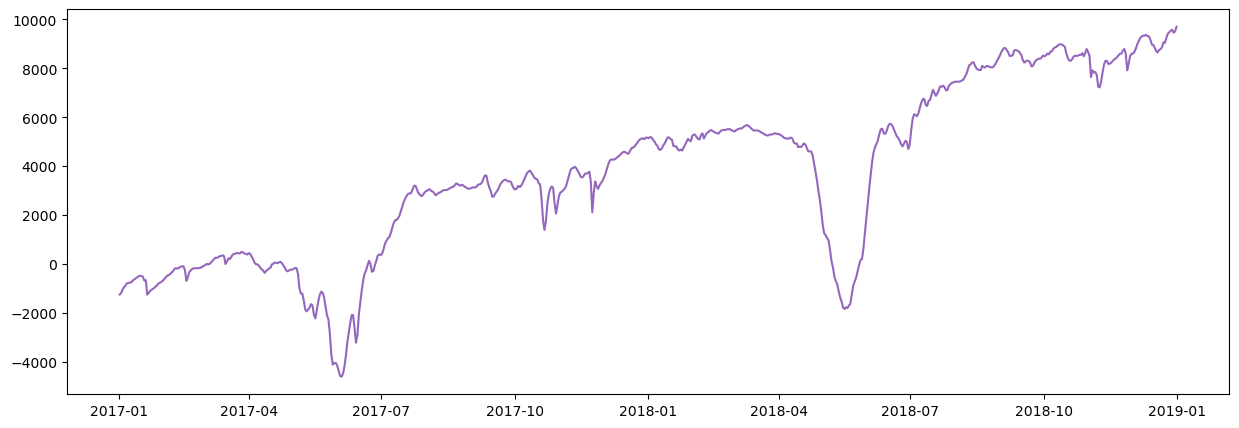

In [68]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

color1 = 'tab:purple'
ax1.plot(time, Fraser_arr/20000-Fraser_obs['DISCHARGE'], color=color1)